<img src="../6-Classification/ReutersNews.png" width="1000">

# <span style="color:purple"> Week 6 - Classification
### <span style="color:purple">Reuters Newspaper</span>  
<span style="color:purple">-- File: Jingying (Jane) Bi Homework 6 <br>
-- Name: Jingying Bi <br>
-- UCID: 12174556 <br>
<br>
    
<span style="color:purple">**Research Object: ** <br>
(1) Classify Reuters newspaper by applying various machine learning models.<br>
(2) Compare all the models according to the evaluation metrics. <br>
(3) Conclude the best performed model training the Reuters Dataset. <br>

<span style="color:purple">Models inclued:
* <span style="color:purple"> Multivariate Naive Bayes (see 2.2)
* <span style="color:purple"> Logistic Regression (see 2.3)
* <span style="color:purple"> Decision Tree (see 3.1)
* <span style="color:purple"> K-Nearest Neighbor (see 4)
* <span style="color:purple"> SVM (see 5.1)
* <span style="color:purple"> MLP (see 5.2)

<br>
<span style="color:purple">**Method: ** <br>
There are 4 main steps. <br>
Step 1: Prepare the corpus. Tokenization, normalization, and splitting the documents into training and testing sets <br>
Step 2: Train the model. Use all the models listed above one by one. <br>
Step 3: Fit/ Test the model. <br>
Step 4: Evaluation. Use test score, confusion matrix, precision, recall, F-measures, and ROC curve to evaluate the models. <br>
<br>
After processing these 4 steps for each of the models, I plot the models' training performances at the end to visualize how each model trains the Reuters Dataset.
<br>
<br>    
    
<span style="color:purple">**Findings: ** <br>
To compare the performance of the models, we could use any metrics, including test score, confusion matrix, precision, recall, F-measures, and ROC curve. Now I will choose to use test score because it directly tells me how well the model predict the testing sets. <br>
(1) Multivariate Naive Bayes Testing score: 0.890818858560794 <br>
(2) Logistic Regression Testing score: 0.8387096774193549 <br>
(3) Decision Tree Testing score: 0.8759305210918115 <br>
(4) K-nearest Neighbor Testing score: 0.6129032258064516
(5) SVM Testing score: 0.8933002481389578 <br>
(6) MLP Testing score: 0.9032258064516129 <br>
Therefore, according to the testing scores. And other metrics make more or less the same conclusions. Multivariate Naive Bayes and SVM perform well also.     
<br>    
    
<span style="color:purple">**Dataset:** <br>
<span style="color:purple"> In this assignment, there are 2017 Reuters News from Oct ~ Dec 2008. Each news on Reuters has a tag marked by the website. I utilize these tags to create three classes. Class *Economy* includes tags "private equity", "global market", and "company". Class *Entertainment* includes tags "art", "film", and "entertainment". Class *Environment* includes tag "environment". 2017 Reuters news have been divided into 1468 *Economy* news, 348 *Entertainment* news and 201 *Environment* news. <br>
    


In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

## <span style="color:purple">1.1 Artificial Dataset and Classifiers
<span style="color:purple">There are five data patterns, including <br>
* <span style="color:purple">random 
* <span style="color:purple">andSplit 
* <span style="color:purple">xorSplit 
* <span style="color:purple">targetSplit
* <span style="color:purple">multiBlobs <br>

<span style="color:purple">There is one parameter noise. Hence, I will choose two values for noise (0.2, 0.8) and use the five patterns to generate 9 distinct artificial datasets. 

### <span style="color:purple"> 1.1.1 Nine Data Patterns
<span style="color:purple">**Interesting Question: ** <br>
For each of the artificialy generated patterns, which machine learning model works best?

<span style="color:purple">**Method: ** <br>
(1) Generate different data patterns <br>
(2) Train each data pattern by models of Bayes, SVC, logistic regressions, decision tree, random forest, mlp and boosting <br>
(3) Evaluate each model for each pattern by the classifier evaluation table, the confusion matrix, and the ROC curve. <br>

<span style="color:purple">**Findings: ** <br>
(1) While generating the data patterns, a larger noise brings higher entropy, which makes the plot more messy and randomly distributed. <br>
(2) andSplit dataset -- the pattern contains two categories separated from one another with some overlap whose extent depends on the noise level. Evaluate the dataset by the classifer evaluation table. The logistic regression works best. <br>
(3) xorSplit dataset -- the pattern is a 2x2 matrix with some overlap between each pair of coordinates. Evaluate the dataset by the confusion matrices. The results are not obvious though, due to lack of specific numerical metric. <br>
(4) MultiBlobs dataset -- several clusters. Evaluate the dataset by the ROC curves. clf_SVC_1, Bayes, Boosting, Reg all perform very well

In [54]:
noise_1 = 0.2
noise_2 = 0.8
dfTrain_1, dfTest_1 = lucem_illud.trainTestSplit(lucem_illud.random())

dfTrain_2, dfTest_2 = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise_1))
dfTrain_3, dfTest_3 = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise_2))

dfTrain_4, dfTest_4 = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise_1)) 
dfTrain_5, dfTest_5 = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise_2))

dfTrain_6, dfTest_6 = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise_1))
dfTrain_7, dfTest_7 = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise_2))

dfTrain_8, dfTest_8 = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise_1))
dfTrain_9, dfTest_9 = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise_2))


****************************** Random ****************************


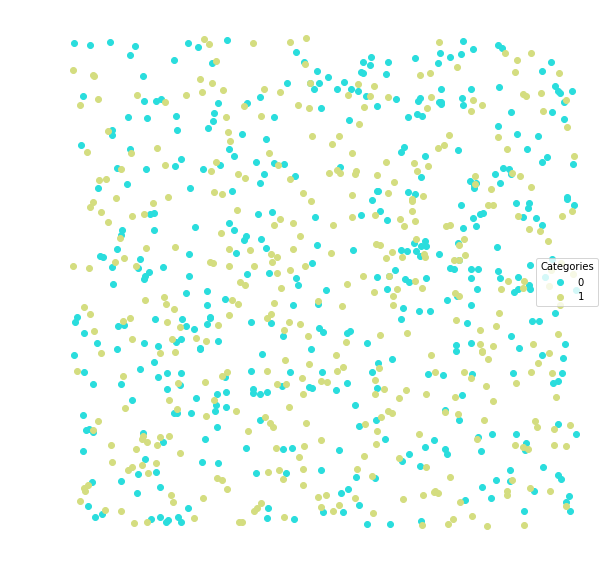

********************* andSplit, noise = 0.2  *********************


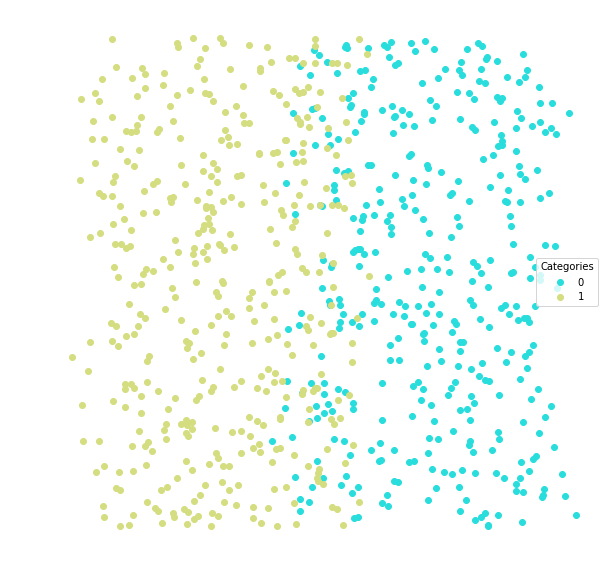

********************* andSplit, noise = 0.8  *********************


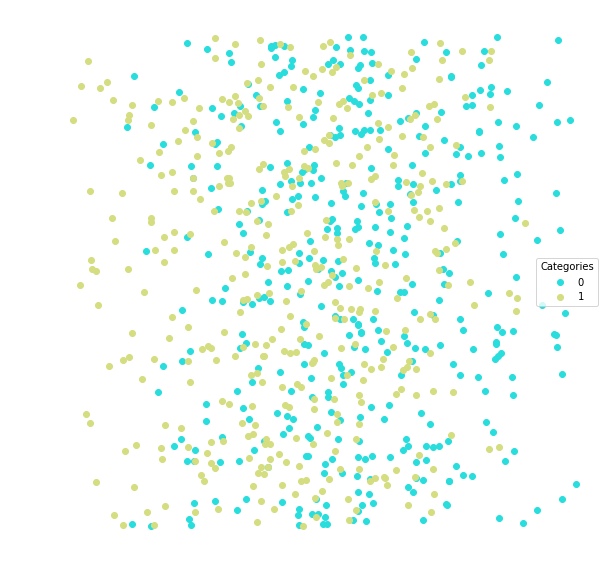

********************* xorSplit, noise = 0.2  *********************


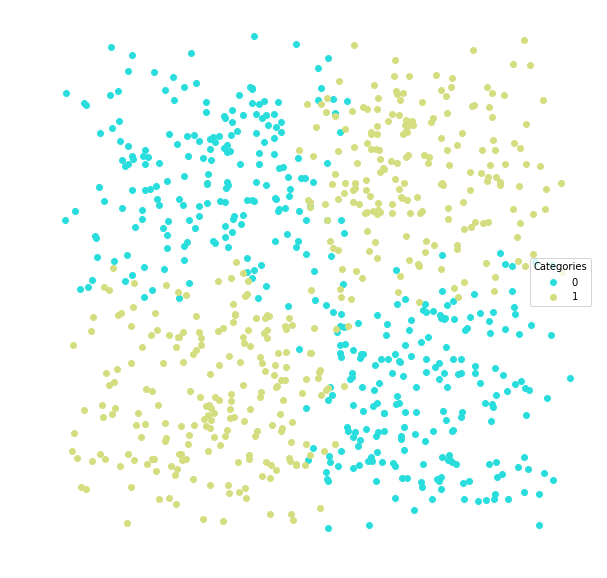

********************* xorSplit, noise = 0.8  *********************


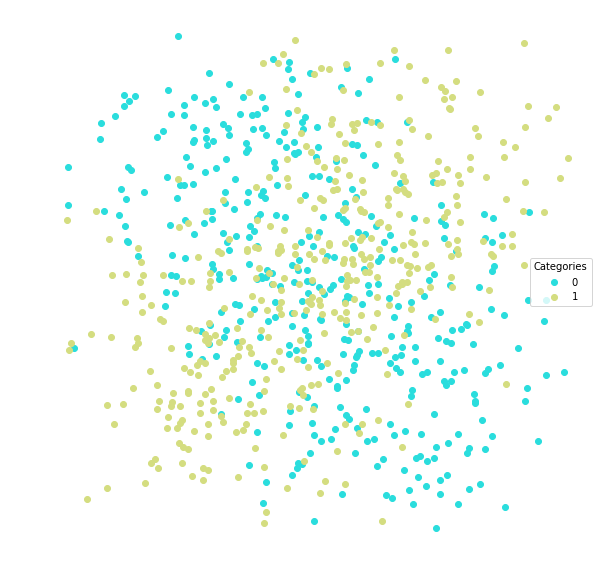

********************* targetSplit, noise = 0.2  *********************


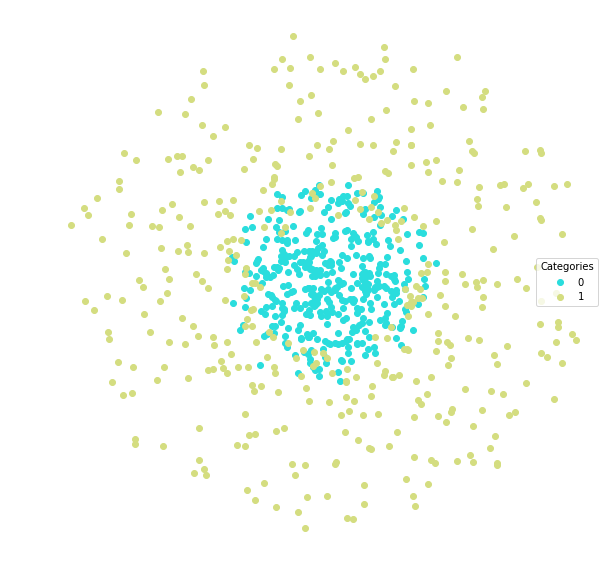

********************* targetSplit, noise = 0.8  *********************


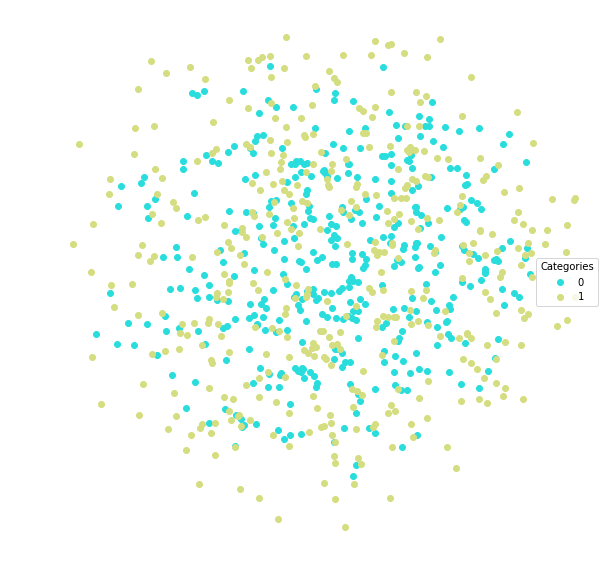

********************* multiBlobs, noise = 0.2  *********************


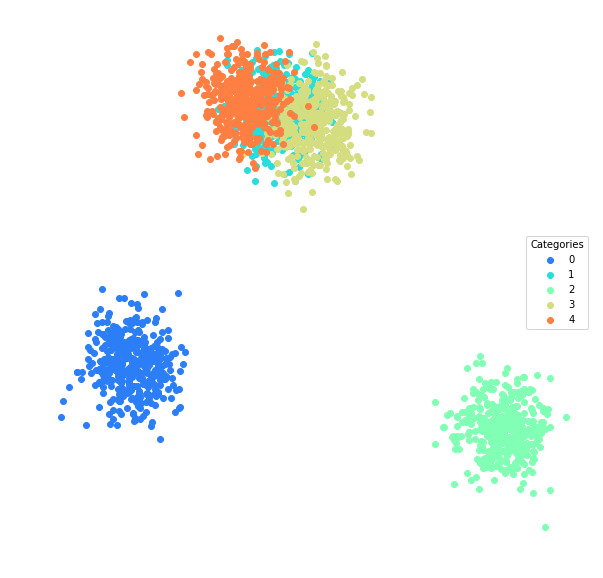

********************* multiBlobs, noise = 0.8  *********************


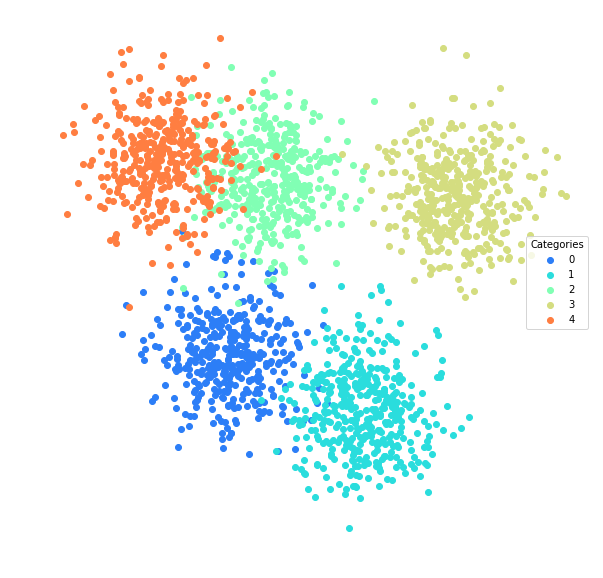

In [55]:
print('****************************** Random ****************************')
lucem_illud.plotter(dfTrain_1)

print('********************* andSplit, noise = 0.2  *********************')
lucem_illud.plotter(dfTrain_2)
print('********************* andSplit, noise = 0.8  *********************')
lucem_illud.plotter(dfTrain_3)

print('********************* xorSplit, noise = 0.2  *********************')
lucem_illud.plotter(dfTrain_4)
print('********************* xorSplit, noise = 0.8  *********************')
lucem_illud.plotter(dfTrain_5)

print('********************* targetSplit, noise = 0.2  *********************')
lucem_illud.plotter(dfTrain_6)
print('********************* targetSplit, noise = 0.8  *********************')
lucem_illud.plotter(dfTrain_7)

print('********************* multiBlobs, noise = 0.2  *********************')
lucem_illud.plotter(dfTrain_8)
print('********************* multiBlobs, noise = 0.8  *********************')
lucem_illud.plotter(dfTrain_9)

### <span style="color:purple"> 1.1.2 Train the Machine Learning Algorithm

In [56]:
#Bayes
clf_Bayes = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf_SVC_1 = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clf_SVC_2 = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf_K = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf_Reg = sklearn.linear_model.LogisticRegression()

#Symbolists
clf_DT = sklearn.tree.DecisionTreeClassifier()
clf_RF = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf_MLP = sklearn.neural_network.MLPClassifier()

#Ensemble
clf_Boosting = sklearn.ensemble.GradientBoostingClassifier()



### <span style="color:purple"> 1.1.3 Fit the Model and Train the Artificial Dataset
<span style="color:purple">I will choose patterns of andSplit, xorSplit, and MultiBlobs.<br>
I will apply clf_SVC_1, clf_Reg, clf_DT to train the model. <br>
Then I will use evaluateClassifier to evaluate the three models on the andSplit dataset <br>
Then I will use plotConfusionMatrix to evaluate the three models on the xorSplit dataset <br>
Then I will use plotMultiROC to evaluate the three models on the MultiBlobs dataset <br>

<span style="color:purple"> ** Interesting Question:** <br> 
<span style="color:purple">Which algorithm models which dataset patterns best? <br>

In [57]:
# andSplit + clf_SVC_1, 1
clf_SVC_1.fit(np.stack(dfTrain_2['vect'], axis=0), dfTrain_2['category'])
# andSplit + clf_Reg
clf_Reg.fit(np.stack(dfTrain_2['vect'], axis=0), dfTrain_2['category'])
# andSplit + clf_DT
clf_DT.fit(np.stack(dfTrain_2['vect'], axis=0), dfTrain_2['category'])
# andSplit + Bayes
clf_Bayes.fit(np.stack(dfTrain_2['vect'], axis=0), dfTrain_2['category'])
# ensembling
clf_Boosting.fit(np.stack(dfTrain_2['vect'], axis=0), dfTrain_2['category'])

# xorSplit + clf_SVC_1, 4
clf_SVC_1.fit(np.stack(dfTrain_4['vect'], axis=0), dfTrain_4['category'])
# xorSplit + clf_Reg
clf_Reg.fit(np.stack(dfTrain_4['vect'], axis=0), dfTrain_4['category'])
# xorSplit+ clf_D
clf_DT.fit(np.stack(dfTrain_4['vect'], axis=0), dfTrain_4['category'])
# xorSplit + Bayes
clf_Bayes.fit(np.stack(dfTrain_4['vect'], axis=0), dfTrain_4['category'])
# ensembling
clf_Boosting.fit(np.stack(dfTrain_4['vect'], axis=0), dfTrain_4['category'])


# MultiBlobs + clf_SVC_1, 8
clf_SVC_1.fit(np.stack(dfTrain_8['vect'], axis=0), dfTrain_8['category'])
# MultiBlobs + clf_Reg
clf_Reg.fit(np.stack(dfTrain_8['vect'], axis=0), dfTrain_8['category'])
# MultiBlobs + clf_DT
clf_DT.fit(np.stack(dfTrain_8['vect'], axis=0), dfTrain_8['category'])
# xorSplit + Bayes
clf_Bayes.fit(np.stack(dfTrain_8['vect'], axis=0), dfTrain_8['category'])
# ensembling
clf_Boosting.fit(np.stack(dfTrain_8['vect'], axis=0), dfTrain_8['category'])


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### <span style="color:purple">1.1.4 Evaluation

#### <span style="color:purple">Evaluate andSplit Dataset
<span style="color:purple"> LogisticRegression performs best.

In [58]:
print('************ andSplit: clf_SVC_1 **************')
lucem_illud.evaluateClassifier(clf_SVC_1, dfTest_2)

************ andSplit: clf_SVC_1 **************


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.324561,0.527251,0.700,0.283333,0.149123
1,0.486842,0.430000,0.445,0.000000,0.000000


In [59]:
print('************ andSplit: clf_Reg **************')
lucem_illud.evaluateClassifier(clf_Reg, dfTest_2)

************ andSplit: clf_Reg **************


/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.19186,0.57,0.835,0.0,0.0
1,0.50000,0.43,0.430,0.0,0.0


In [60]:
print('************ andSplit: clf_DT **************')
lucem_illud.evaluateClassifier(clf_DT, dfTest_2)

************ andSplit: clf_DT **************


/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.5,0.57,0.43,0.57,1.0
1,0.5,0.43,0.43,0.00,0.0


In [61]:
print('************ andSplit: clf_Bayes **************')
lucem_illud.evaluateClassifier(clf_Bayes, dfTest_2)

************ andSplit: clf_Bayes **************


/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.447674,0.57,0.615,0.0,0.0
1,0.500000,0.43,0.430,0.0,0.0


In [62]:
print('************ andSplit: clf_Boosting **************')
lucem_illud.evaluateClassifier(clf_Boosting, dfTest_2)

************ andSplit: clf_Boosting **************


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.488372,0.57,0.580,0.0,0.0
1,0.495614,0.43,0.435,0.0,0.0


#### <span style="color:purple"> Evaluate xorSplit Dataset


************ xorSplit: clf_SVC_1 **************


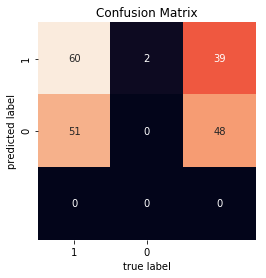

In [63]:
print('************ xorSplit: clf_SVC_1 **************')
lucem_illud.plotConfusionMatrix(clf_SVC_1, dfTest_4)

************ xorSplit: clf_Reg **************


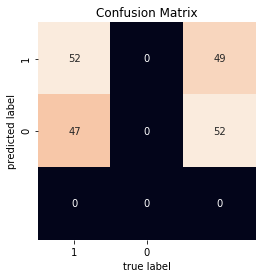

In [64]:
print('************ xorSplit: clf_Reg **************')
lucem_illud.plotConfusionMatrix(clf_Reg, dfTest_4)

************ xorSplit: clf_DT **************


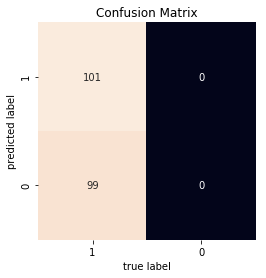

In [65]:
print('************ xorSplit: clf_DT **************')
lucem_illud.plotConfusionMatrix(clf_DT, dfTest_4)

************ xorSplit: clf_Bayes **************


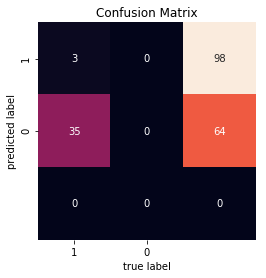

In [66]:
print('************ xorSplit: clf_Bayes **************')
lucem_illud.plotConfusionMatrix(clf_Bayes, dfTest_4)

************ xorSplit: clf_Boosting **************


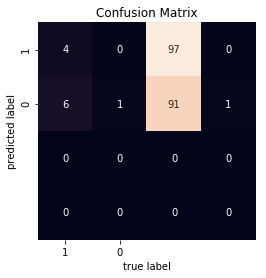

In [67]:
print('************ xorSplit: clf_Boosting **************')
lucem_illud.plotConfusionMatrix(clf_Boosting, dfTest_4)

#### <span style="color:purple"> Evaluate MultiBlobs Dataset
<span style="color:purple"> clf_SVC_1, Bayes, Boosting, Reg all perform very well

************ MultiBlobs: clf_SVC_1 **************


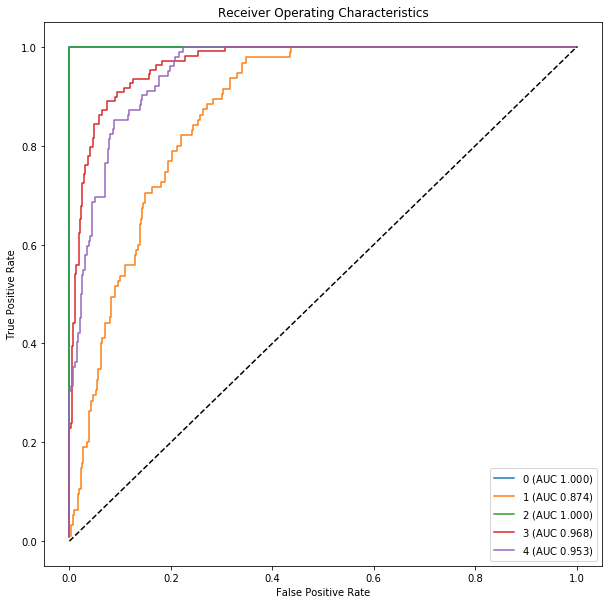

In [68]:
print('************ MultiBlobs: clf_SVC_1 **************')
lucem_illud.plotMultiROC(clf_SVC_1, dfTest_8)

************ MultiBlobs: clf_Reg **************


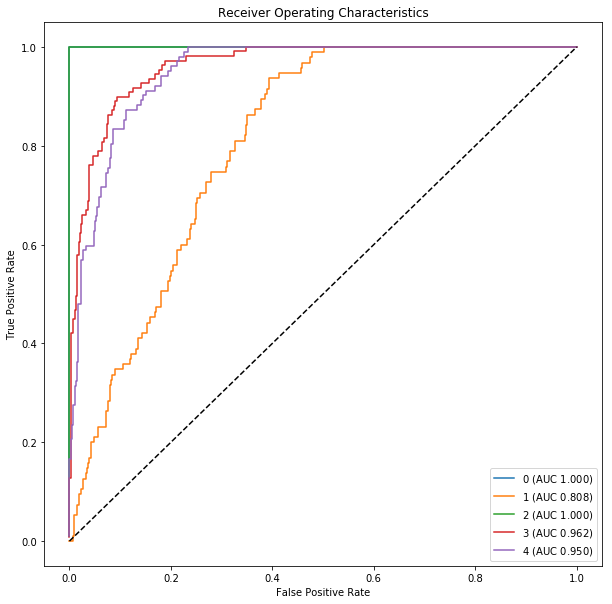

In [69]:
print('************ MultiBlobs: clf_Reg **************')
lucem_illud.plotMultiROC(clf_Reg, dfTest_8)

************ MultiBlobs: clf_DT **************


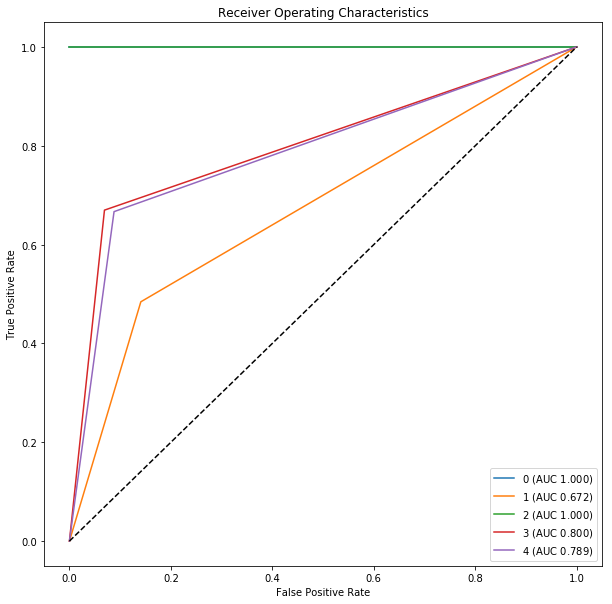

In [70]:
print('************ MultiBlobs: clf_DT **************')
lucem_illud.plotMultiROC(clf_DT, dfTest_8)

************ MultiBlobs: clf_Bayes **************


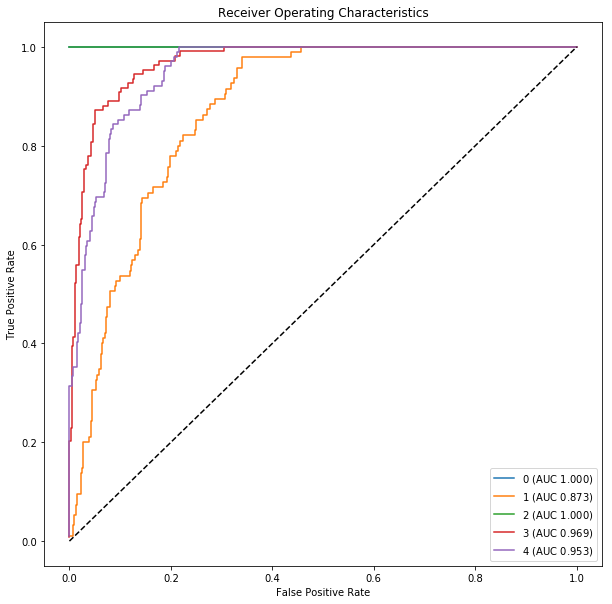

In [71]:
print('************ MultiBlobs: clf_Bayes **************')
lucem_illud.plotMultiROC(clf_Bayes, dfTest_8)

************ MultiBlobs: clf_Boosting **************


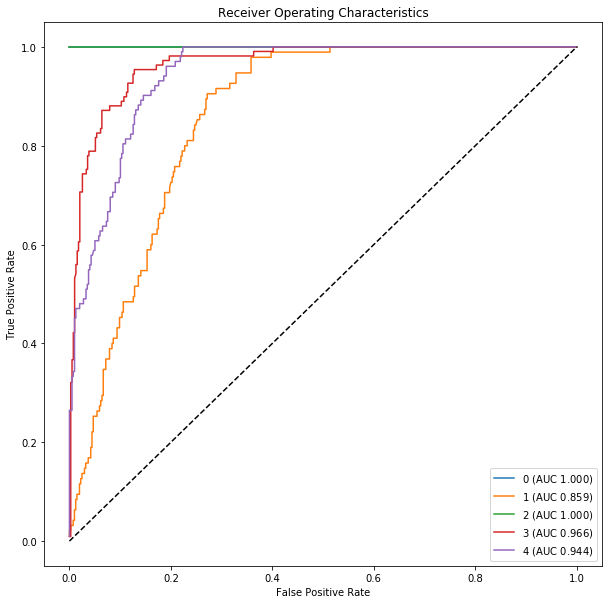

In [72]:
print('************ MultiBlobs: clf_Boosting **************')
lucem_illud.plotMultiROC(clf_Boosting, dfTest_8)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


## <span style="color:purple"> 2.1 Load Data
    
<span style="color:purple"> Now let's start the discussion about the classification models on Reuters News.

In [2]:
# load data
ReutersDF = pandas.read_csv('Reuters_2017News.csv')
ReutersDF.rename(columns ={'Topic': 'category'}, inplace=True)
ReutersDF[:3]
target_categories = ['economy', 'environment', 'entertainment']

# normalize
ReutersDF['tokenized_text'] = ReutersDF['News'].apply(lambda x: nltk.word_tokenize(x))
ReutersDF['normalized_text'] = ReutersDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

In [3]:
ReutersDF[:3]

,Unnamed: 0,Year,Month,Day,Title,category,News,Link,tokenized_text,normalized_text
0,0,2008,12,1,"Earthquake rattles Taiwan, no reports of damage",environment,Reuters Staff1 Min ReadTAIPEI (Reuters) - An e...,http://www.reuters.com/article/environmentNews...,"[Reuters, Staff1, Min, ReadTAIPEI, (, Reuters,...","[reuter, min, readtaipei, reuter, earthquak, m..."
1,1,2008,12,1,TREASURIES-Rise in Asia after Bernanke talks o...,economy,Reuters Staff3 Min Read * Treasuries edge up i...,http://www.reuters.com/article/companyNewsAndP...,"[Reuters, Staff3, Min, Read, *, Treasuries, ed...","[reuter, min, read, treasuri, edg, asia, ralli..."
2,2,2008,12,1,GLOBAL MARKETS-Asia stocks slide as global out...,economy,Reuters Staff4 Min Read * Asian shares fall 3-...,http://www.reuters.com/article/companyNewsAndP...,"[Reuters, Staff4, Min, Read, *, Asian, shares,...","[reuter, min, read, asian, share, fall, pct, w..."


## <span style="color:purple"> 2.2 Multivariate Naive Bayes

### <span style="color:purple"> 2.2.1 Train the Model

In [4]:
# split the train and test
holdBackFraction = .2
train_Reuters_B, test_Reuters_B = lucem_illud.trainTestSplit(ReutersDF, holdBackFraction=holdBackFraction)
print(len(train_Reuters_B))
print(len(test_Reuters_B))

# Train 
# (1) TF-IDF
TFVectorizer_Reuters = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_Reuters = TFVectorizer_Reuters.fit_transform(train_Reuters_B['News'])
train_Reuters_B['vect'] = [np.array(v).flatten() for v in TFVects_Reuters.todense()]

# (2) Train the model
MultinomialNB_Reuters = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_Reuters.fit(np.stack(train_Reuters_B['vect'], axis = 0), train_Reuters_B['category'])

# (3) Save testing predictions to the dataframe train_Reuters
train_Reuters_B['nb_predict_NB'] = MultinomialNB_Reuters.predict(np.stack(train_Reuters_B['vect'], axis=0))


1614
403


### <span style="color:purple"> 2.2.2 Fit/ Test the Model

In [5]:
#Create vectors
TFVects_test = TFVectorizer_Reuters.transform(test_Reuters_B['News'])
test_Reuters_B['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_Reuters_B['nb_predict_NB'] = MultinomialNB_Reuters.predict(np.stack(test_Reuters_B['vect'], axis=0))

# true
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_Reuters_B['vect'], axis=0))

# Naive Bayes
#pca = sklearn.decomposition.PCA()
#reduced_data_NB = pca.fit_transform(np.stack(train_Reuters_B['vect'], axis=0))

### <span style="color:purple">2.2.3 Evaluation 
<span style="color:purple"> I will use different methods to evaluate the Multinomial Naive Bayes model.
* <span style="color:purple">Test score
* <span style="color:purple">Confusion Matrix
* <span style="color:purple">Calculate the precision, recall, and F-measures
* <span style="color:purple">Performance table
* <span style="color:purple">ROC curve

In [6]:
# (1) Test score
print("Testing score:")
print(MultinomialNB_Reuters.score(np.stack(test_Reuters_B['vect'], axis=0), test_Reuters_B['category']))

Testing score:
0.8660049627791563


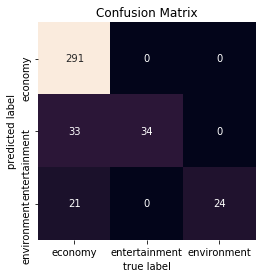

In [7]:
# (2) confusion matrix
lucem_illud.plotConfusionMatrix(MultinomialNB_Reuters, test_Reuters_B)

In [8]:
# (3) Let's calculate the precision, recall, and F-measures.
print('The precision is ', sklearn.metrics.precision_score(test_Reuters_B['nb_predict_NB'], test_Reuters_B['category'], average = 'weighted')) #precision
print('The recall is ', sklearn.metrics.recall_score(test_Reuters_B['nb_predict_NB'], test_Reuters_B['category'], average = 'weighted')) #recall
print('The F-measure is ', sklearn.metrics.f1_score(test_Reuters_B['nb_predict_NB'], test_Reuters_B['category'], average = 'weighted')) #F-1 measure

The precision is  0.930654420206659
The recall is  0.8660049627791563
The F-measure is  0.881623544547482


In [9]:
# (4) Performance table
lucem_illud.metrics.evaluateClassifier(MultinomialNB_Reuters, test_Reuters_B)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
economy,0.758929,0.843478,0.133995,0.843478,1.000000
environment,0.766667,0.585443,0.052109,1.000000,0.533333
entertainment,0.753731,0.589349,0.081886,1.000000,0.507463


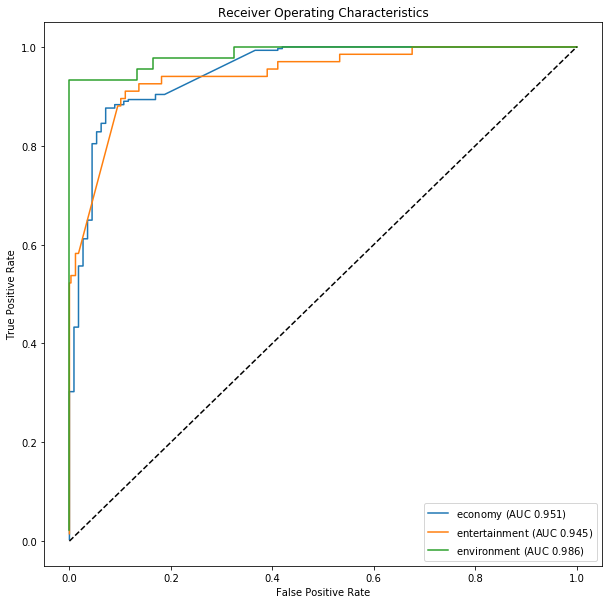

In [10]:
# ROC curve
lucem_illud.plotMultiROC(MultinomialNB_Reuters, test_Reuters_B)

## <span style="color:purple"> 2.3 Logistic Regression

### <span style="color:purple"> 2.3.1 Train the Model

In [11]:
# split the train and test
holdBackFraction = .2
train_Reuters_Reg, test_Reuters_Reg = lucem_illud.trainTestSplit(ReutersDF, holdBackFraction=holdBackFraction)
print(len(train_Reuters_Reg))
print(len(test_Reuters_Reg))

# Train 
# (1) TF-IDF
TFVectorizer_Reuters = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_Reuters = TFVectorizer_Reuters.fit_transform(train_Reuters_Reg['News'])
train_Reuters_Reg['vect'] = [np.array(v).flatten() for v in TFVects_Reuters.todense()]

# (2) Train the model
Reg_Reuters = sklearn.linear_model.LogisticRegression()
Reg_Reuters.fit(np.stack(train_Reuters_Reg['vect'], axis = 0), train_Reuters_Reg['category'])

# (3) Save testing predictions to the dataframe train_Reuters
train_Reuters_Reg['nb_predict_Reg'] = Reg_Reuters.predict(np.stack(train_Reuters_Reg['vect'], axis=0))


1614
403


### <span style="color:purple"> 2.3.2 Fit/ Test the Model

In [12]:
#Create vectors
TFVects_test = TFVectorizer_Reuters.transform(test_Reuters_Reg['News'])
test_Reuters_Reg['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_Reuters_Reg['nb_predict_Reg'] = Reg_Reuters.predict(np.stack(test_Reuters_Reg['vect'], axis=0))

In [13]:
# logistic regression
reduced_data_Reg = pca.fit_transform(np.stack(train_Reuters_Reg['vect'], axis=0))

### <span style="color:purple"> 2.3.3  Evaluation 
<span style="color:purple">I will use different methods to evaluate the Multinomial Naive Bayes model.
* <span style="color:purple">Test score
* <span style="color:purple">Confusion Matrix
* <span style="color:purple">Calculate the precision, recall, and F-measures
* <span style="color:purple">Performance table
* <span style="color:purple">ROC curve

In [14]:
# (1) Test score
print("Testing score:")
print(Reg_Reuters.score(np.stack(test_Reuters_Reg['vect'], axis=0), test_Reuters_Reg['category']))

Testing score:
0.8808933002481389


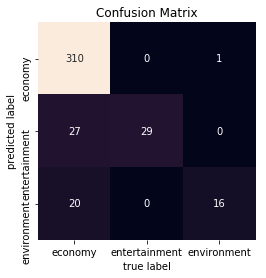

In [15]:
# (2) confusion matrix
lucem_illud.plotConfusionMatrix(Reg_Reuters, test_Reuters_Reg)

In [9]:
# (3) Let's calculate the precision, recall, and F-measures.
print('The precision is ', sklearn.metrics.precision_score(test_Reuters_Reg['nb_predict_Reg'], test_Reuters_Reg['category'], average = 'weighted')) #precision
print('The recall is ', sklearn.metrics.recall_score(test_Reuters_Reg['nb_predict_Reg'], test_Reuters_Reg['category'], average = 'weighted')) #recall
print('The F-measure is ', sklearn.metrics.f1_score(test_Reuters_Reg['nb_predict_Reg'], test_Reuters_Reg['category'], average = 'weighted')) #F-1 measure

The precision is  0.9328648225082858
The recall is  0.8486352357320099
The F-measure is  0.8711197563700148


In [10]:
# (4) Performance table
lucem_illud.metrics.evaluateClassifier(Reg_Reuters, test_Reuters_Reg)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
economy,0.730088,0.826211,0.151365,0.826211,1.000000
entertainment,0.763158,0.615646,0.089330,1.000000,0.526316
environment,0.662162,0.386359,0.062035,1.000000,0.324324


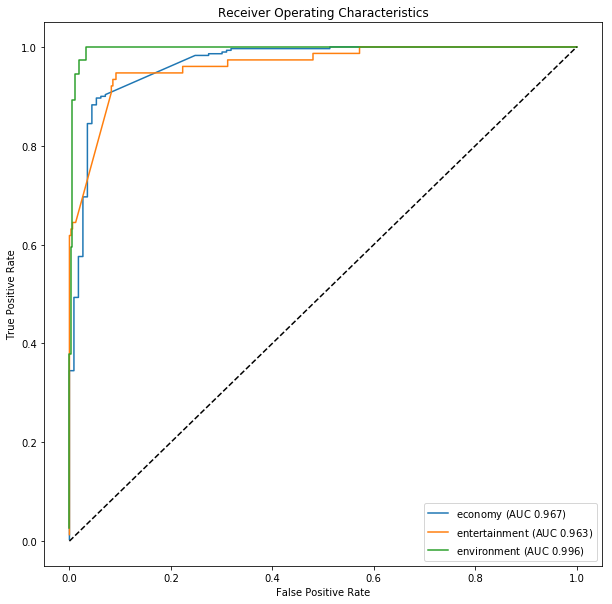

In [11]:
# ROC curve
lucem_illud.plotMultiROC(Reg_Reuters, test_Reuters_Reg)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

## <span style="color:purple"> 3.1 Decision Tree

### <span style="color:purple"> 3.1.1 Train the Model

In [16]:
# split the train and test
holdBackFraction = .2
train_Reuters_DT, test_Reuters_DT = lucem_illud.trainTestSplit(ReutersDF, holdBackFraction=holdBackFraction)
print(len(train_Reuters_DT))
print(len(test_Reuters_DT))

# Train 
# (1) TF-IDF
TFVectorizer_Reuters = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_Reuters = TFVectorizer_Reuters.fit_transform(train_Reuters_DT['News'])
train_Reuters_DT['vect'] = [np.array(v).flatten() for v in TFVects_Reuters.todense()]

# (2) Train the model
DT_Reuters = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
DT_Reuters.fit(np.stack(train_Reuters_DT['vect'], axis = 0), train_Reuters_DT['category'])

# (3) Save testing predictions to the dataframe train_Reuters
train_Reuters_DT['nb_predict_DT'] = DT_Reuters.predict(np.stack(train_Reuters_DT['vect'], axis=0))


1614
403


### <span style="color:purple"> 3.1.2 Fit/ Test the Model

In [17]:
#Create vectors
TFVects_test = TFVectorizer_Reuters.transform(test_Reuters_DT['News'])
test_Reuters_DT['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_Reuters_DT['nb_predict_DT'] = DT_Reuters.predict(np.stack(test_Reuters_DT['vect'], axis=0))

### <span style="color:purple"> 3.1.3  Evaluation 

In [14]:
# (1) Test score
print("Testing score:")
print(DT_Reuters.score(np.stack(test_Reuters_DT['vect'], axis=0), test_Reuters_DT['category']))

Testing score:
0.8684863523573201


In [15]:
lucem_illud.evaluateClassifier(DT_Reuters, test_Reuters_DT)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
economy,0.778167,0.851409,0.131514,0.853293,0.986159
entertainment,0.721598,0.520612,0.091811,0.966667,0.446154
environment,0.863110,0.710437,0.039702,0.923077,0.734694


In [41]:
a = sklearn.metrics.accuracy_score(test_Reuters_DT['category'],DT_Reuters.predict(np.stack(test_Reuters_DT['vect'], axis = 0)))
print('The accuracy rate is ', a)

The accuracy rate is  0.8560794044665012


### <span style="color:purple"> 3.1.4 Trim the tree

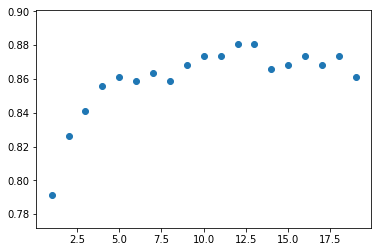

In [42]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_Reuters_DT['vect'], axis =0), train_Reuters_DT['category'])
    score = sklearn.metrics.accuracy_score(test_Reuters_DT['category'], tree2.predict(np.stack(test_Reuters_DT['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

## <span style="color:purple">  3.2 Random Forest

In [43]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=7) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

bag.fit(np.stack(train_Reuters_DT['vect'], axis =0), train_Reuters_DT['category']) #Fit the bagged classifier


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

In [44]:
lucem_illud.evaluateClassifier(bag, test_Reuters_DT)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
entertainment,0.711283,0.501041,0.104218,0.937500,0.428571
economy,0.748328,0.851062,0.131514,0.851429,0.996656
environment,0.808824,0.649905,0.032258,1.000000,0.617647


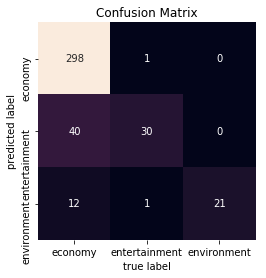

In [45]:
lucem_illud.plotConfusionMatrix(bag, test_Reuters_DT)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

## <span style="color:purple">  4 K-Nearest Neighbor

### <span style="color:purple"> 4.1 Train the Model

In [52]:
holdBackFraction = .2
train_Reuters_K, test_Reuters_K = lucem_illud.trainTestSplit(ReutersDF, holdBackFraction=holdBackFraction)

n_neighbors = 3
weights="uniform"


# Train 
# (1) TF-IDF
TFVectorizer_Reuters = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_Reuters = TFVectorizer_Reuters.fit_transform(train_Reuters_K['News'])
train_Reuters_K['vect'] = [np.array(v).flatten() for v in TFVects_Reuters.todense()]

# (2) Train the model
K_Reuters = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
K_Reuters.fit(np.stack(train_Reuters_K['vect'], axis = 0), train_Reuters_K['category'])

# (3) Save testing predictions to the dataframe train_Reuters
train_Reuters_K['nb_predict_K'] = K_Reuters.predict(np.stack(train_Reuters_K['vect'], axis=0))



### <span style="color:purple"> 4.2 Fit/ Test the Model

In [17]:
#Create vectors
TFVects_test = TFVectorizer_Reuters.transform(test_Reuters_K['News'])
test_Reuters_K['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_Reuters_K['nb_predict_K'] = K_Reuters.predict(np.stack(test_Reuters_K['vect'], axis=0))

In [ ]:
# k-nearest
pca = sklearn.decomposition.PCA()
reduced_data_K = pca.fit_transform(np.stack(train_Reuters_K['vect'], axis=0))

### <span style="color:purple"> 4.3  Evaluation 

In [16]:
# (1) Test score
print("Testing score:")
print(K_Reuters.score(np.stack(test_Reuters_K['vect'], axis=0), test_Reuters_K['category']))

Testing score:
0.6129032258064516


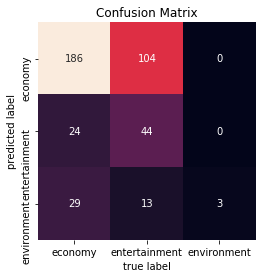

In [49]:
# (2) confusion matrix
lucem_illud.plotConfusionMatrix(K_Reuters, test_Reuters_K)

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

## <span style="color:purple"> 5.1 SVMs

### <span style="color:purple"> 5.1.1 Train the Model

In [5]:
holdBackFraction = .2
train_Reuters_SVM, test_Reuters_SVM = lucem_illud.trainTestSplit(ReutersDF, holdBackFraction=holdBackFraction)

# Train 
# (1) TF-IDF
TFVectorizer_Reuters = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_Reuters = TFVectorizer_Reuters.fit_transform(train_Reuters_SVM['News'])
train_Reuters_SVM['vect'] = [np.array(v).flatten() for v in TFVects_Reuters.todense()]

# (2) Train the model
SVM_Reuters = sklearn.svm.SVC(kernel='linear', probability = False)
SVM_Reuters.fit(np.stack(train_Reuters_SVM['vect'], axis = 0), train_Reuters_SVM['category'])

# (3) Save testing predictions to the dataframe train_Reuters
train_Reuters_SVM['nb_predict_SVM'] = SVM_Reuters.predict(np.stack(train_Reuters_SVM['vect'], axis=0))



### <span style="color:purple"> 5.1.2 Fit/ Test the Model

In [6]:
#Create vectors
TFVects_test = TFVectorizer_Reuters.transform(test_Reuters_SVM['News'])
test_Reuters_SVM['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_Reuters_SVM['nb_predict_SVM'] = SVM_Reuters.predict(np.stack(test_Reuters_SVM['vect'], axis=0))


### <span style="color:purple"> 5.1.3  Evaluation 

In [52]:
# (1) Test score
print("Testing score:")
print(SVM_Reuters.score(np.stack(test_Reuters_SVM['vect'], axis=0), test_Reuters_SVM['category']))

Testing score:
0.8933002481389578


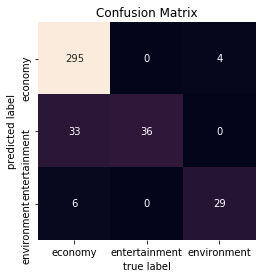

In [53]:
# (2) confusion matrix
lucem_illud.plotConfusionMatrix(SVM_Reuters, test_Reuters_SVM)

## <span style="color:purple">  5.2 Neural Nets

### <span style="color:purple"> 5.2.1 Train the Model

In [3]:
# MLP -- Multi-layer Percepron
holdBackFraction = .2
train_Reuters_MLP, test_Reuters_MLP = lucem_illud.trainTestSplit(ReutersDF, holdBackFraction=holdBackFraction)

# Train 
# (1) TF-IDF
TFVectorizer_Reuters = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_Reuters = TFVectorizer_Reuters.fit_transform(train_Reuters_MLP['News'])
train_Reuters_MLP['vect'] = [np.array(v).flatten() for v in TFVects_Reuters.todense()]

# (2) Train the model
MLP_Reuters = sklearn.neural_network.MLPClassifier()
MLP_Reuters.fit(np.stack(train_Reuters_MLP['vect'], axis = 0), train_Reuters_MLP['category'])

# (3) Save testing predictions to the dataframe train_Reuters
train_Reuters_MLP['nb_predict_MLP'] = MLP_Reuters.predict(np.stack(train_Reuters_MLP['vect'], axis=0))



### <span style="color:purple"> 5.2.2 Fit/ Test the Model

In [4]:
#Create vectors
TFVects_test = TFVectorizer_Reuters.transform(test_Reuters_MLP['News'])
test_Reuters_MLP['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_Reuters_MLP['nb_predict_MLP'] = MLP_Reuters.predict(np.stack(test_Reuters_MLP['vect'], axis=0))


### <span style="color:purple"> 5.2.3  Evaluation 

In [10]:
# (1) Test score
print("Testing score:")
print(MLP_Reuters.score(np.stack(test_Reuters_MLP['vect'], axis=0), test_Reuters_MLP['category']))

Testing score:
0.9032258064516129


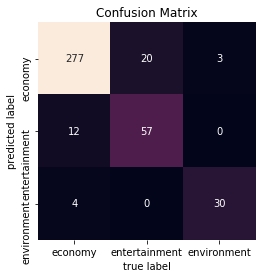

In [11]:
# (2) confusion matrix
lucem_illud.plotConfusionMatrix(MLP_Reuters, test_Reuters_MLP)

## Some Extra Visualization

In [48]:
# true categories
train_Reuters_B['C']=train_Reuters_B['category']
train_Reuters_B.loc[train_Reuters_B.category == 'economy', 'C'] = 0
train_Reuters_B.loc[train_Reuters_B.category == 'entertainment', 'C'] = 1
train_Reuters_B.loc[train_Reuters_B.category == 'environment', 'C'] = 2

# Logistic Regression predicitons
train_Reuters_Reg['Reg']=train_Reuters_Reg['nb_predict_Reg']
train_Reuters_Reg.loc[train_Reuters_Reg.nb_predict_Reg == 'economy', 'Reg'] = 0
train_Reuters_Reg.loc[train_Reuters_Reg.nb_predict_Reg == 'entertainment', 'Reg'] = 1
train_Reuters_Reg.loc[train_Reuters_Reg.nb_predict_Reg == 'environment', 'Reg'] = 2

# Decision Tree predictions
train_Reuters_DT['DT']=train_Reuters_DT['nb_predict_DT']

train_Reuters_DT.loc[train_Reuters_DT.nb_predict_DT == 'economy', 'DT'] = 0
train_Reuters_DT.loc[train_Reuters_DT.nb_predict_DT == 'entertainment', 'DT'] = 1
train_Reuters_DT.loc[train_Reuters_DT.nb_predict_DT == 'environment', 'DT'] = 2

colordict = {
'economy': 'orange',
'environment': 'green',
'entertainment': 'blue',
'NaN': 'black'}


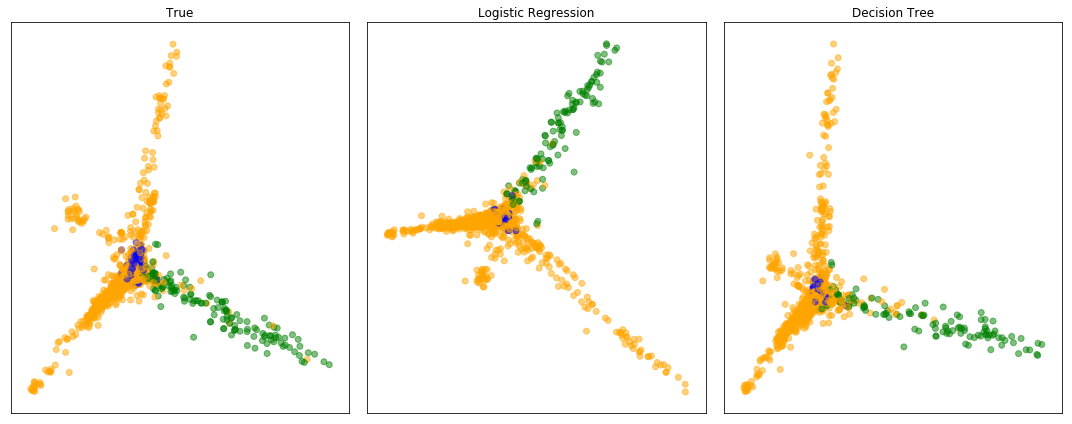

In [51]:
target_categories = ['economy',  'entertainment','environment','NaN']
plt.figure(figsize = (15,6))

# true 3
plt.subplot(131)
colors_p3 = [colordict[target_categories[l]] for l in train_Reuters_B['C']]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p3, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('True')

# logistic regession 4
plt.subplot(132)
colors_p4 = [colordict[target_categories[l]] for l in train_Reuters_Reg['Reg']]
plt.scatter(reduced_data_Reg[:, 0], reduced_data_Reg[:, 1], color = colors_p4, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Logistic Regression')

# decision tree 5
plt.subplot(133)
colors_p5 = [colordict[target_categories[l]] for l in train_Reuters_DT['DT']]
plt.scatter(reduced_data_DT[:, 0], reduced_data_DT[:, 1], color = colors_p5, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Decision Tree')

plt.tight_layout()
plt.show()

<span style="color:purple">**Findings: ** <br>
Previously, we discovered that the performance of MLP is the best. Multivariate Naive Bayes and SVM perform well also. The visualization above displays the training results of some models. In addition to logistic regression and decision tree. I also have the ones for Naive Bayes and K-nearest Neighbor. It is clear that the decision tree, logit and Naive Bayes perform well. This is consistent with the evaluation metrics.
<img src="../6-Classification/extra.png" width="600">

<span style="color:purple">**Findings: ** <br>
In conclusion, most of the models perform well. The training performances of logit, decision tree and bayes are good. However, it will be better to further plot the testing performance, because the training performance only tells us how well the trained model alligns with the given dataset. 

<span style="color:purple"><span style="color:purple">*----------------END----------------* <br>
<span style="color:purple">February 14th, 2018 at Regenstein Library <br>
<span style="color:purple">Jingying Bi <br>